# Simulator Developer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import buskit as bk
from buskit import busdata as bdata
from buskit import dashboard as bdash
from buskit import simulator as bsim

from IPython.display import display, clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# specify path to the archive AVL file
# archive_path = 'MTA_data/B46%2B-180716-171100-44650-Mon.csv'
# archive_path = 'MTA_data/B15-180705-145946-44650-Thu.csv'
archive_path = 'MTA_data/B15-180625-235941-44650-Mon.csv'

# parse stops and set links
stops, links, stop_pos = bsim.set_route(archive_path, 1)

# create empty dictionary storage for bus objects
live_bus = {} # for buses from archive streaming
active_bus = {} # for buses in the simulator

# Original trajectory

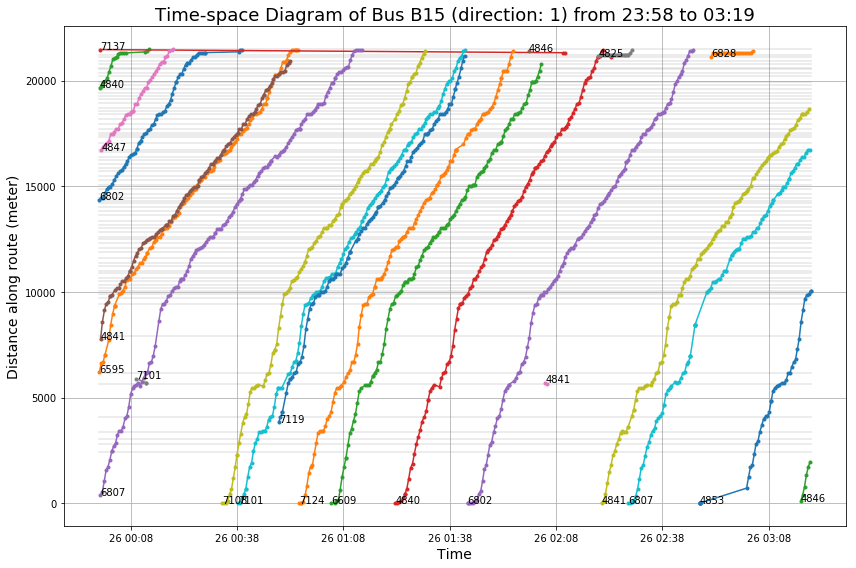

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x113a246a0>)

In [3]:
# plot TSD for cross-validation
df = pd.read_csv(archive_path)
df = bdata.split_trips(df)
bdata.plot_tsd(df, 1, 0, 201)

# Simulation without control

In [3]:
# run simulation without control
bsim.simulate(archive_path, 1, live_bus, active_bus, stops, links, stop_pos, False, sim_time=200)

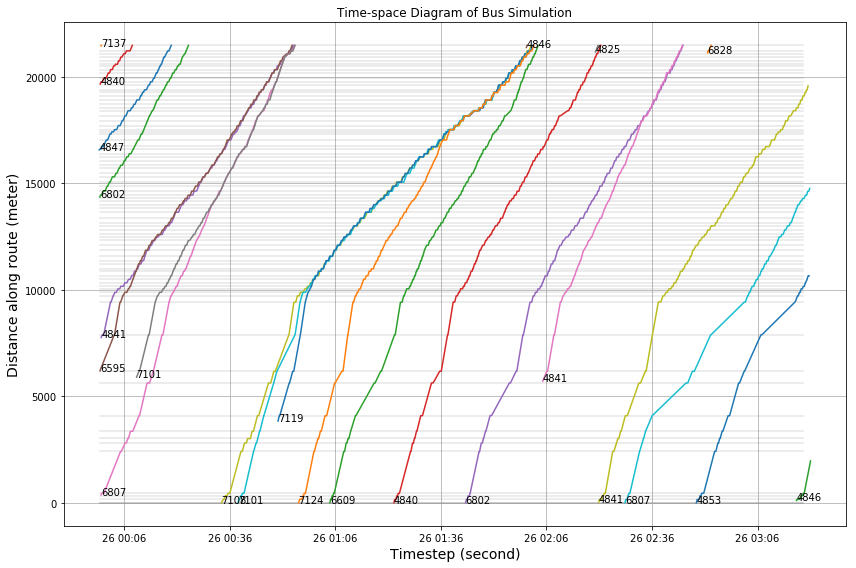

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10d3adcf8>)

In [4]:
bsim.sim_tsd(active_bus, stops, archive_path, 1, 0, 200)

# Simulation with control
### Hold bus within 10 minute headway for 1 minute at each stop until relieved

In [5]:
# reset
stops, links, stop_pos = bsim.set_route(archive_path, 1)
live_bus = {}
active_bus = {}

In [6]:
# run simulation with control
bsim.simulate(archive_path, 1, live_bus, active_bus, stops, links, stop_pos, True, sim_time=200)

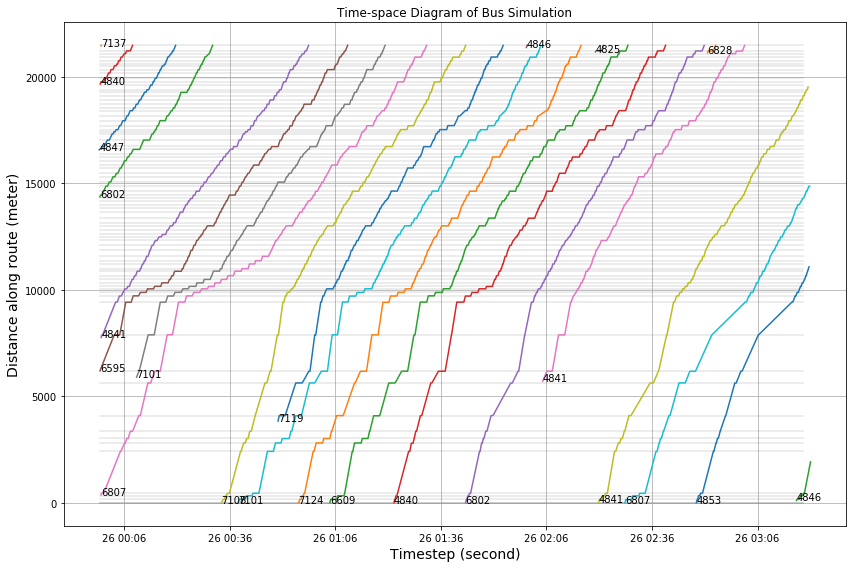

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11aa3e908>)

In [7]:
bsim.sim_tsd(active_bus, stops, archive_path, 1, 0, 200)

In [ ]:
- Time gap between streaming and simulation
- Remove/solve incomplete vehicle pings?
- eliminate convergence; different dwelling time settings
- Holding Strategies； in dense run setting

def eval_sim(bus_dict1, bus_dict2, duration):
    buses1 = set(bus_dict1.keys())
    buses2 = set(bus_dict2.keys())
    >>> intersect = 
    sim_mse = [] # mse from all runs
    for ref in intersect:
        >>> align by time
        >>> based on live_bus location (30-sec interval)
        bus_dict1[ref].pos
        bus_dict2[ref].pos
        
        err = [array of difference btwn pos lists]
        mse = np.mean(err^2)
        sim_mse.append(mse)
    result = np.mean(sim_mse) / duration
    return result # mse per run per time unit
    
def eval_strategy(bus_dict):
    headway
    wait_time
    in-vehicle traveling time
    delay
    delay for different OD pairs
    bunching (how to eval?)
    spacing

In [31]:
# bsim.infer(archive_path, 1, live_bus, stops, links, stop_pos, 360)

# speeds = [np.mean(l.log_speed) for l in links.values() if np.mean(l.log_speed) != nan]
# speeds = np.array(speeds)[~np.isnan(speeds)]

# mean([mean(l.log_speed) for l in links.values() if len(l.log_speed) > 0])

# speeds = [l.log_speed for l in links.values() if np.mean(l.log_speed) != nan]
# flat_list = [item for sublist in speeds for item in sublist if item < 25]

# plt.hist(flat_list, bins=100)

###

# d = [s.log_dwell_t for s in stops.values()]
# w = [s.log_wait_t for s in stops.values()]

# d_flat = [item for sublist in d for item in sublist]
# w_flat = [item for sublist in w for item in sublist]

# qs = [s.log_q for s in stops.values()]
# qs = [item for sublist in qs for item in sublist if item < 1]
# plt.hist(qs)

/Users/Yuwen/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Yuwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
